# Introduction and Project Objective

This project is the M5 forecasting competion hosted by www.kaggle.com.  The objective is to forecast 28 days of sales.  Walmart donated sales data recorded from January 29, 2011 to June 19, 2016.  The sales data is hierarchical data set.  The following graphic shows how the data set is broken down.

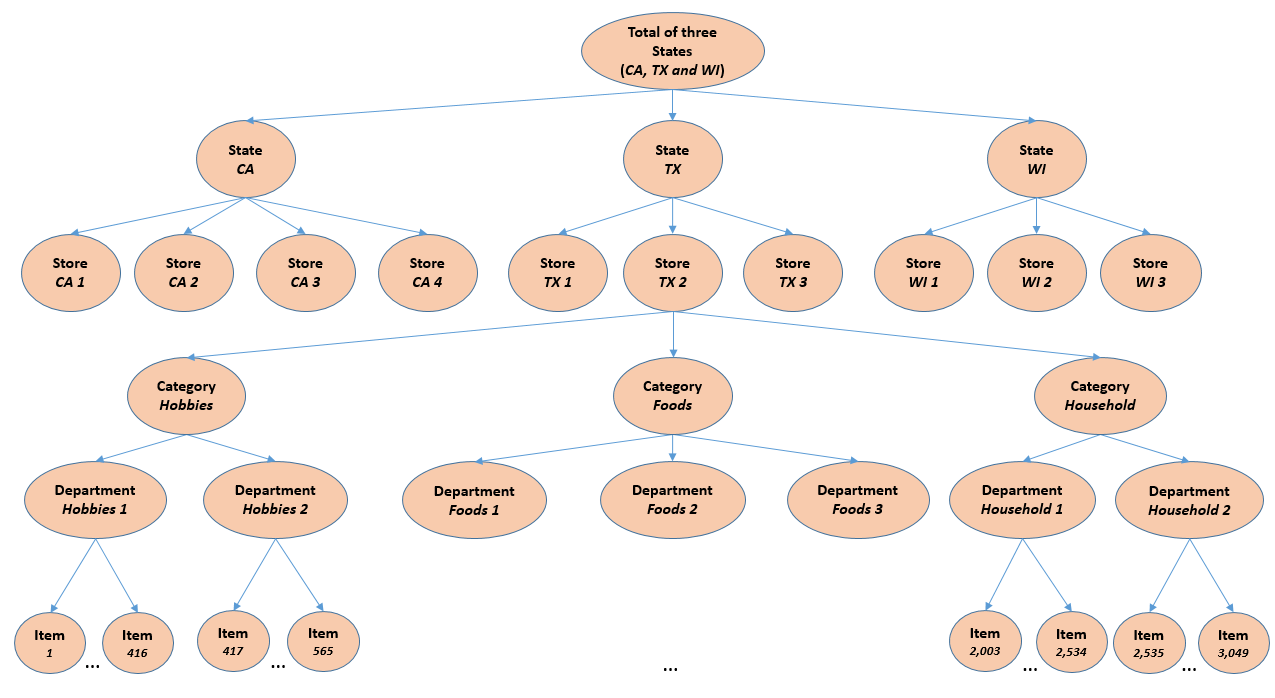

Reference for graphic:

MOFC. (2020). The M5 Competition Competitor's Guide. Retrieved from: https://mofc.unic.ac.cy/m5-competition/

In this hierarchical time series dataset, the break down is the products are sold in three states: California, Texas, and Wisconsin.  In California there are four stores, Texas there are three stores, and Wisconsin there are three stores.  The three categories of the products sold are hobbies, foods, and household.  

# Dataset Description
Retrieved from:

www.kaggle.com/gopidurgaprasad/m5-forecasting-eda

There are four files which contain a different dataset in each file.  The description of each file is below.

## File 1: calendar.csv
Contains the dates on which products are sold. The dates are in a yyyy/dd/mm format.

date: The date in a “y-m-d” format.

wm_yr_wk: The id of the week the date belongs to.

weekday: The type of the day (Saturday, Sunday, ..., Friday).

wday: The id of the weekday, starting from Saturday.

month: The month of the date.

year: The year of the date.

event_name_1: If the date includes an event, the name of this event.

event_type_1: If the date includes an event, the type of this event.

event_name_2: If the date includes a second event, the name of this event.

event_type_2: If the date includes a second event, the type of this event.

snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP 3 purchases on the examined date. 1 indicates that SNAP purchases are allowed.

## File 2: sales_train_validation.csv
Contains the historical daily unit sales data per product and store [d_1 - d_1913].

item_id: The id of the product.

dept_id: The id of the department the product belongs to.

cat_id: The id of the category the product belongs to.

store_id: The id of the store where the product is sold.

state_id: The State where the store is located.
d_1, d_2, ..., d_i, ... d_1941: The number of units sold at day i, starting from 2011-01-29.

## File 3: sell_prices.csv
Contains information about the price of the products sold per store and date.

store_id: The id of the store where the product is sold.

item_id: The id of the product.

wm_yr_wk: The id of the week.

sell_price: The price of the product for the given week/store. The price is 
provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. 

Note that although prices are constant at weekly basis, they may change through time (both training and test set).

## File 4: submission.csv
Demonstrates the correct format for submission to the competition.

Each row contains an id that is a concatenation of an item_id and a store_id, which is either validation (corresponding to the Public leaderboard), or evaluation (corresponding to the Private leaderboard). You are predicting 28 forecast days (F1-F28) of items sold for each row. For the validation rows, this corresponds to d_1914 - d_1941, and for the evaluation rows, this corresponds to d_1942 - d_1969. (Note: a month before the competition close, the ground truth for the validation rows will be provided.)


# Load Libraries

In [2]:
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from pathlib import Path
from sklearn.utils import shuffle
import tqdm as tqdm
import regex as re

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
pd.plotting.register_matplotlib_converters()
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

# Loading Data

##  Calendar Dataframe

In [3]:
# Load calendar dataframe.
calendar_df = pd.read_csv('calendar.csv')

In [4]:
# Display first few rows of calendar_df.
calendar_df.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  1/29/2011     11101   Saturday     1      1  2011  d_1          NaN   
1  1/30/2011     11101     Sunday     2      1  2011  d_2          NaN   
2  1/31/2011     11101     Monday     3      1  2011  d_3          NaN   
3   2/1/2011     11101    Tuesday     4      2  2011  d_4          NaN   
4   2/2/2011     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [5]:
# Display last few rows of calendar_df.
calendar_df.tail()

date  wm_yr_wk    weekday  wday  month  year       d  event_name_1  \
1964  6/15/2016     11620  Wednesday     5      6  2016  d_1965           NaN   
1965  6/16/2016     11620   Thursday     6      6  2016  d_1966           NaN   
1966  6/17/2016     11620     Friday     7      6  2016  d_1967           NaN   
1967  6/18/2016     11621   Saturday     1      6  2016  d_1968           NaN   
1968  6/19/2016     11621     Sunday     2      6  2016  d_1969  NBAFinalsEnd   

     event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
1964          NaN           NaN          NaN        0        1        1  
1965          NaN           NaN          NaN        0        0        0  
1966          NaN           NaN          NaN        0        0        0  
1967          NaN           NaN          NaN        0        0        0  
1968     Sporting  Father's day     Cultural        0        0        0

In [6]:
# Display information about each column in calendar_df.
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [7]:
# Number of rows and columns for calendar_df.
calendar_df.shape

(1969, 14)

In [8]:
# Check for missing values.
calendar_df.isnull().sum()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

##  Sell Price Dataframe

In [9]:
# Load selling prices dataset.
selling_prices_df = pd.read_csv('sell_prices.csv') 

In [10]:
# Display the first few rows of selling_prices_df.
selling_prices_df.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [11]:
# Display the last few rows of selling_prices_df.
selling_prices_df.tail()

store_id      item_id  wm_yr_wk  sell_price
6841116     WI_3  FOODS_3_827     11617         1.0
6841117     WI_3  FOODS_3_827     11618         1.0
6841118     WI_3  FOODS_3_827     11619         1.0
6841119     WI_3  FOODS_3_827     11620         1.0
6841120     WI_3  FOODS_3_827     11621         1.0

In [12]:
# Display information about each column in selling_prices_df.
selling_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [13]:
# Number of rows and columns for selling_prices_df.
selling_prices_df.shape

(6841121, 4)

In [14]:
# Check for missing values.
selling_prices_df.isnull().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

##  Sales Dataframe

In [15]:
# Load sales train validation dataset.
sales_train_valid_df = pd.read_csv('sales_train_validation.csv')

In [16]:
# Display the first few rows of the sales_train_valid_df.
sales_train_valid_df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [17]:
# Display the last few rows of the sales_train_valid_df.
sales_train_valid_df.tail()

id      item_id  dept_id cat_id store_id  \
30485  FOODS_3_823_WI_3_validation  FOODS_3_823  FOODS_3  FOODS     WI_3   
30486  FOODS_3_824_WI_3_validation  FOODS_3_824  FOODS_3  FOODS     WI_3   
30487  FOODS_3_825_WI_3_validation  FOODS_3_825  FOODS_3  FOODS     WI_3   
30488  FOODS_3_826_WI_3_validation  FOODS_3_826  FOODS_3  FOODS     WI_3   
30489  FOODS_3_827_WI_3_validation  FOODS_3_827  FOODS_3  FOODS     WI_3   

      state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  \
30485       WI    0    0    2    2  ...       2       0       0       0   
30486       WI    0    0    0    0  ...       0       0       0       0   
30487       WI    0    6    0    2  ...       2       1       0       2   
30488       WI    0    0    0    0  ...       0       0       1       0   
30489       WI    0    0    0    0  ...       0       0       0       0   

       d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
30485       0       0       1       0       0       1  
30486       0       0       0       0       1       0  
30487       0       1       0       0       1       0  
30488       0       1       0       3       1       3  
30489       0       0       0       0       0       0  

[5 rows x 1919 columns]

In [18]:
# Display the information of each column of sales_train_valid_df.
sales_train_valid_df.dtypes

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1909       int64
d_1910       int64
d_1911       int64
d_1912       int64
d_1913       int64
Length: 1919, dtype: object

In [19]:
# Display the number of rows and columns for sales_train_valid_df.
sales_train_valid_df.shape

(30490, 1919)

In [20]:
# Check for missing values.
sales_train_valid_df.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1909      0
d_1910      0
d_1911      0
d_1912      0
d_1913      0
Length: 1919, dtype: int64

##  Submission Dataframe

In [21]:
# Load sample_submission dataset.
sample_sub_df = pd.read_csv('sample_submission.csv')

In [22]:
# Display the first few rows of sample_sub_df.
sample_sub_df.head()

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  \
0  HOBBIES_1_001_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
1  HOBBIES_1_002_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
2  HOBBIES_1_003_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
3  HOBBIES_1_004_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
4  HOBBIES_1_005_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   

   F19  F20  F21  F22  F23  F24  F25  F26  F27  F28  
0    0    0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0    0    0    0  

[5 rows x 29 columns]

In [23]:
# Display the last few rows of sample_sub_df.
sample_sub_df.tail()

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  \
60975  FOODS_3_823_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60976  FOODS_3_824_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60977  FOODS_3_825_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60978  FOODS_3_826_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60979  FOODS_3_827_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   

       F19  F20  F21  F22  F23  F24  F25  F26  F27  F28  
60975    0    0    0    0    0    0    0    0    0    0  
60976    0    0    0    0    0    0    0    0    0    0  
60977    0    0    0    0    0    0    0    0    0    0  
60978    0    0    0    0    0    0    0    0    0    0  
60979    0    0    0    0    0    0    0    0    0    0  

[5 rows x 29 columns]

# Summary Statistics

Retrieved from: 

https://www.kaggle.com/anirbansen3027/m5-forecasting-eda-beginner

In [24]:
# Create a variable for dates.
date_col = [col for col in sales_train_valid_df if col.startswith('d_')]

CA    12196
WI     9147
TX     9147
Name: state_id, dtype: int64


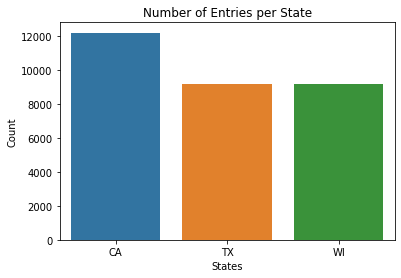

In [25]:
# Count the number of data entries for CA, TX, and WI.
sales_state_count = sales_train_valid_df.state_id.value_counts()
print(sales_state_count)

# Create bar plot for the state counts.
sns.countplot('state_id', data=sales_train_valid_df)
plt.xlabel('States')
plt.ylabel('Count')
plt.title('Number of Entries per State')
plt.show()

In [26]:
# Display the percentages for the number of data entries for CA, TX, and WI.
percent_state = sales_train_valid_df.state_id.value_counts()/sales_train_valid_df.shape[0] * 100
print(percent_state)

CA    40.0
WI    30.0
TX    30.0
Name: state_id, dtype: float64


In [27]:
# Sum the sales to create a new column called sales.
sales_train_valid_df['total_sales'] = sales_train_valid_df[date_col].sum(axis=1)

In [28]:
# Display the total sales for each state.
sales_train_valid_df.groupby('state_id').agg({'total_sales':'sum'}).reset_index()

state_id  total_sales
0       CA     28675547
1       TX     18899006
2       WI     18120856

In [29]:
# Display the total sales as percentages for each state.
sales_train_valid_df.groupby('state_id').agg({'total_sales':'sum'})/sales_train_valid_df.total_sales.sum() * 100

total_sales
state_id             
CA          43.649240
TX          28.767621
WI          27.583139

In [30]:
# Display the total sales as percentages for each store.
sales_train_valid_df.groupby('store_id').agg({'total_sales':'sum'})/sales_train_valid_df.total_sales.sum() * 100

total_sales
store_id             
CA_1        11.718043
CA_2         8.654296
CA_3        17.030383
CA_4         6.246519
TX_1         8.517021
TX_2        10.981565
TX_3         9.269034
WI_1         7.837781
WI_2         9.961141
WI_3         9.784218

I see California has the highest sales among the three states.  This is in part because it has four stores versus the other two states have three stores.  California has a higher population among the three states, so this is another explanation for higher sales.

In [31]:
# Display the total sales for each category.
sales_train_valid_df.groupby('cat_id').agg({'total_sales':'sum'}).reset_index()

cat_id  total_sales
0      FOODS     45089939
1    HOBBIES      6124800
2  HOUSEHOLD     14480670

In [32]:
# Display the total sales as percentages for each category.
sales_train_valid_df.groupby('cat_id').agg({'total_sales':'sum'})/sales_train_valid_df.total_sales.sum() * 100

total_sales
cat_id                
FOODS        68.634840
HOBBIES       9.323026
HOUSEHOLD    22.042134

In [33]:
# Create a table to display total sales percentages for each category in each state.
sales_train_valid_df.groupby(['cat_id', 'state_id']).agg({'total_sales':'sum'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

total_sales                      
state_id           CA         TX         WI
cat_id                                     
FOODS       42.573360  28.734616  28.692024
HOBBIES     49.632364  25.998220  24.369416
HOUSEHOLD   44.468674  30.041745  25.489580

In [34]:
# Create a table to display total sales percentages for each state in each category.
sales_train_valid_df.groupby(['state_id', 'cat_id']).agg({'total_sales':'sum'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

total_sales                      
cat_id         FOODS    HOBBIES  HOUSEHOLD
state_id                                  
CA         66.943107  10.600959  22.455934
TX         68.556098   8.425517  23.018385
WI         71.394067   8.236796  20.369137

In [35]:
# Display the total sales as percentages for each department.
sales_train_valid_df.groupby('dept_id').agg({'total_sales':'sum'})/sales_train_valid_df.total_sales.sum() * 100

total_sales
dept_id                 
FOODS_1         7.744896
FOODS_2        11.613935
FOODS_3        49.276010
HOBBIES_1       8.518799
HOBBIES_2       0.804227
HOUSEHOLD_1    17.505829
HOUSEHOLD_2     4.536305

In [36]:
# Create a table to display total sales percentages for each state in each category.
sales_train_valid_df.groupby(['store_id', 'dept_id']).agg({'total_sales':'sum'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

total_sales                                                         \
dept_id      FOODS_1    FOODS_2    FOODS_3  HOBBIES_1 HOBBIES_2 HOUSEHOLD_1   
store_id                                                                      
CA_1        7.376371  11.498041  51.022666  10.671615  0.716452   14.291168   
CA_2       12.623167   5.852088  42.737907  10.171235  1.046878   19.468066   
CA_3        6.586076  10.748540  49.841547   7.914764  0.674185   19.190548   
CA_4        8.371275  13.093504  47.240084  13.204210  0.550653   12.937790   
TX_1        6.535066  11.286507  49.703215   6.899086  0.769576   20.478574   
TX_2        7.048641  10.831999  51.634984   7.771571  1.044109   17.384977   
TX_3        6.757065  12.385139  49.224726   7.553655  1.105064   19.053607   
WI_1        9.840666  11.668028  45.267585  11.810365  0.923916   15.981066   
WI_2        8.113585  16.696776  48.052953   5.019734  0.637560   18.562283   
WI_3        6.204706  12.624853  54.767834   6.627481  0.632691   15.831682   

                      
dept_id  HOUSEHOLD_2  
store_id              
CA_1        4.423687  
CA_2        8.100660  
CA_3        5.044341  
CA_4        4.602483  
TX_1        4.327978  
TX_2        4.283720  
TX_3        3.920743  
WI_1        4.508375  
WI_2        2.917110  
WI_3        3.310753

According to the tables above, I observed the food category generates the highest sales, household category generates the second highest sales, and hobbies generate lowest sales.  People tend to purchase more food than the other categories because food is a necessity to survive.  

# EDA

Retrieved from:

https://www.kaggle.com/zachary3141/m5-beginner-eda-cnn

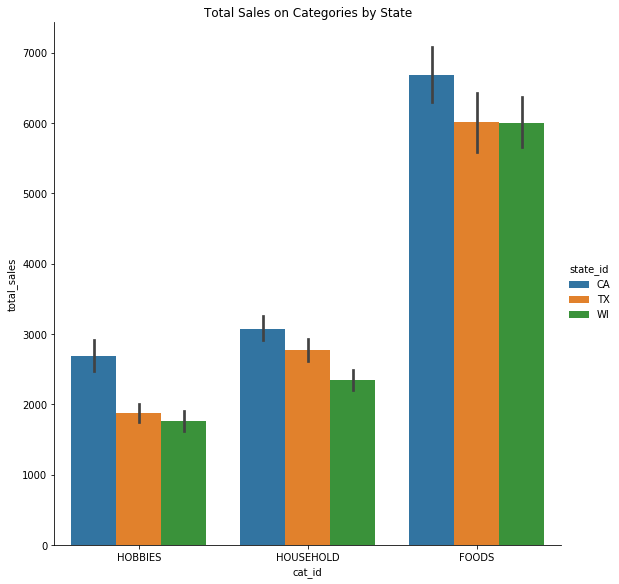

In [37]:
# Plot the total sales for categories by state.
sales_train_valid_df['total_sales'] = sales_train_valid_df.sum(axis=1)
sns.catplot(x='cat_id', y='total_sales',
           hue='state_id',
           data=sales_train_valid_df, kind='bar',
           height=8, aspect=1)
plt.title('Total Sales on Categories by State')
plt.show()

Below is the line plots of the population for each state since the 1900's.  I can see the California has the highest population, Texas the next highest population, and Wisconsin has the lowest population.

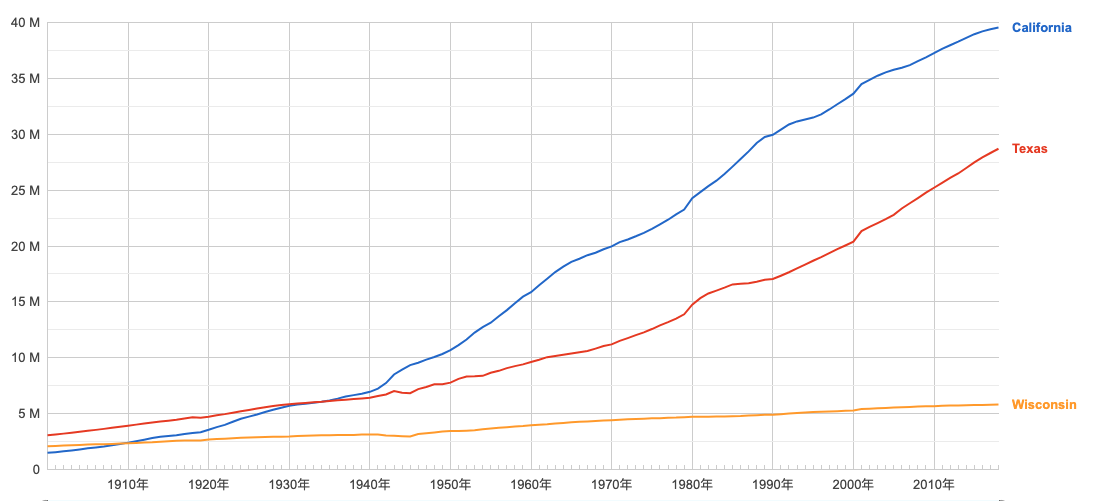

Retrieved from: https://i.imgur.com/bUSEoMb.png

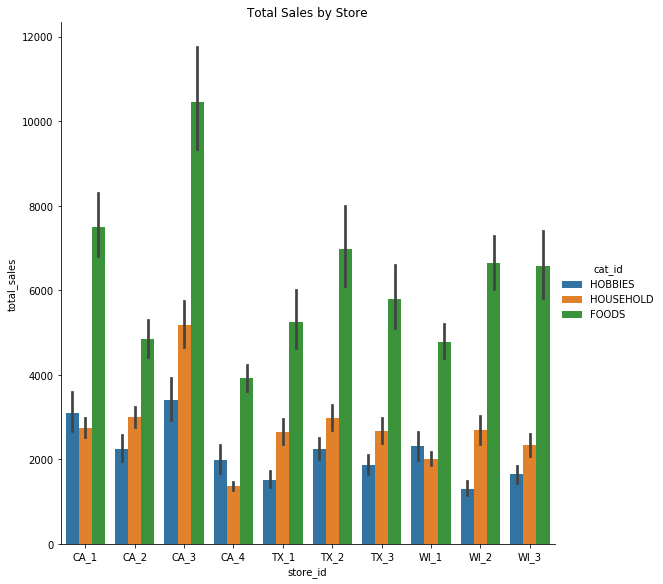

In [38]:
# Plot the total sales by store.
sns.catplot(x='store_id', y='total_sales',
           hue='cat_id',
           data=sales_train_valid_df, kind='bar',
           height=8, aspect=1)
plt.title('Total Sales by Store')
plt.show()

The plot displays CA_3 store has the highest sales among all the stores.  Walmart leaders may want to investigate why and how CA_3 store has the highest sales and replicate what CA_3 store is doing to have the highest sales.

In [39]:
# Create variables to plot the sales for each category and state.
hobbies_state = sales_train_valid_df.loc[(sales_train_valid_df['cat_id'] == 'HOBBIES')].groupby(['state_id']).mean().T
hobbies_state = hobbies_state.rename({'CA': 'HOBBIES_CA', 'TX': 'HOBBIES_TX', 'WI': 'HOBBIES_WI'}, axis=1)
household_state = sales_train_valid_df.loc[(sales_train_valid_df['cat_id'] == 'HOUSEHOLD')].groupby(['state_id']).mean().T
household_state = household_state.rename({'CA': 'HOUSEHOLD_CA', 'TX': 'HOUSEHOLD_TX', 'WI': 'HOUSEHOLD_WI'}, axis=1)
foods_state = sales_train_valid_df.loc[(sales_train_valid_df['cat_id'] == 'FOODS')].groupby(['state_id']).mean().T
foods_state = foods_state.rename({'CA': 'FOODS_CA', 'TX': 'FOODS_TX', 'WI': 'FOODS_WI'}, axis=1)
nine_example = pd.concat([hobbies_state, household_state, foods_state], axis=1)
nine_example = nine_example.drop('total_sales')

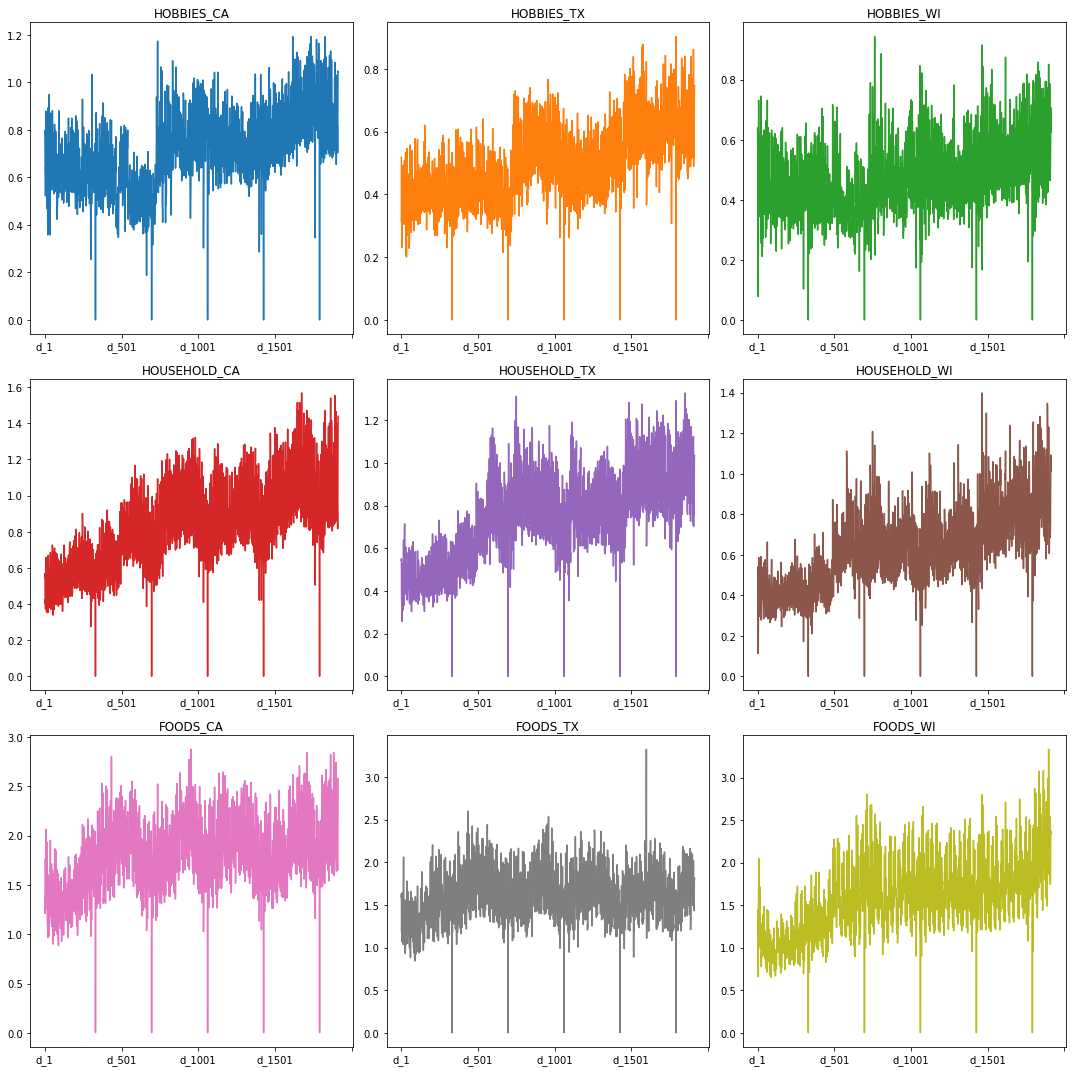

In [40]:
# PLot the sales for each category and state.
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

fig, axs = plt.subplots(3, 3, figsize=(15,15))
axs = axs.flatten()
ax_idx = 0
for item in nine_example.columns:
    nine_example[item].plot(title=item, color=next(color_cycle), ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

An observation of all the graphs is there are days where sales are zero.  This might be because the stores were closed for a holiday.  I will display plots later to show the different holidays.  These plots will explain the flucatuation of sales.  According to these plots, I can see there is seasonality that exists.  This means the sales are cyclical.  One explanation for the cyclical plots is during some holidays sales are higher for food such as Thanksgiving and Super Bowl than other days.

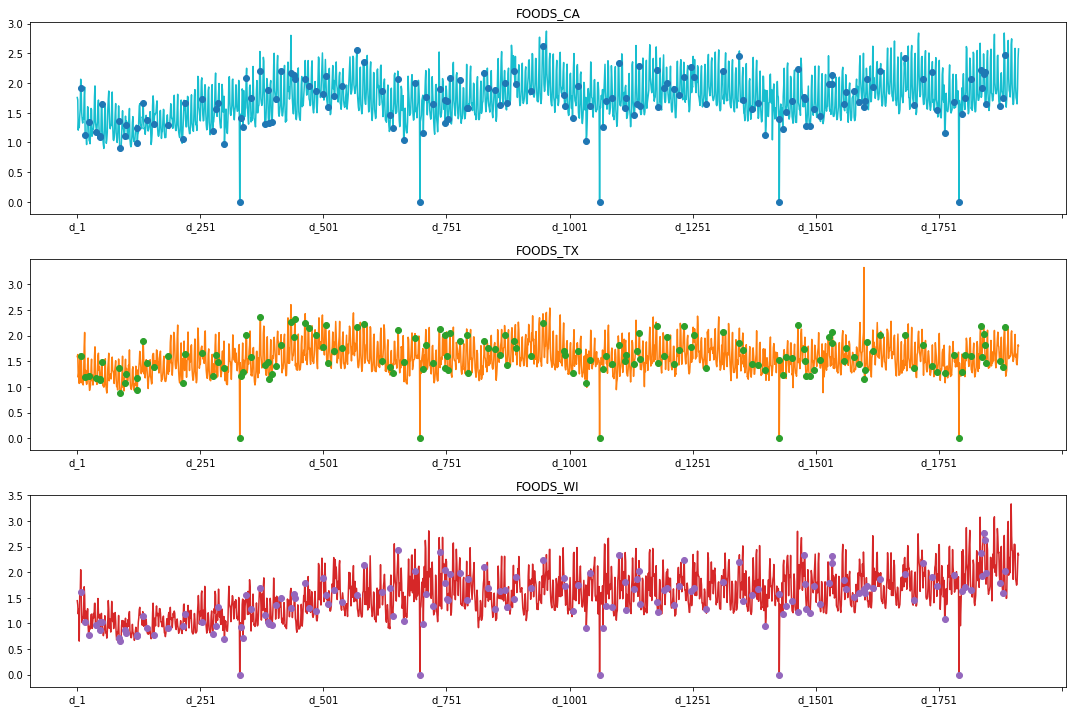

In [41]:
# Plot holidays' and special events' sales for food among the three states.
event_date = calendar_df.loc[calendar_df['event_name_1'].isin(calendar_df.event_name_1.unique()[1:])].d
FOODS_event = sales_train_valid_df.loc[(sales_train_valid_df['cat_id'] == 'FOODS')].groupby(['state_id']).mean().T.reset_index()
FOODS_event = FOODS_event.loc[FOODS_event['index'].isin(event_date)]
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
nine_example['FOODS_CA'].plot(title='FOODS_CA', color=next(color_cycle))
plt.scatter(FOODS_event.reset_index().level_0, FOODS_event['CA'],color=next(color_cycle), zorder=10)
plt.subplot(3,1,2)
nine_example['FOODS_TX'].plot(title='FOODS_TX', color=next(color_cycle))
plt.scatter(FOODS_event.reset_index().level_0, FOODS_event['TX'],color=next(color_cycle), zorder=10)
plt.subplot(3,1,3)
nine_example['FOODS_WI'].plot(title='FOODS_WI', color=next(color_cycle))
plt.scatter(FOODS_event.reset_index().level_0, FOODS_event['WI'],color=next(color_cycle), zorder=10)
plt.tight_layout()
plt.show()

According to the plots above, I can see among the three states there are days with zero sales which is Christmas.  I can observe the days before and after Christmas there are higher food sales than other day, and these days are Thanksgiving and the Super Bowl. 

Target looks like classification
Showing only top 10 of 1909 continuous features
Linear Discriminant Analysis training set score: 0.447


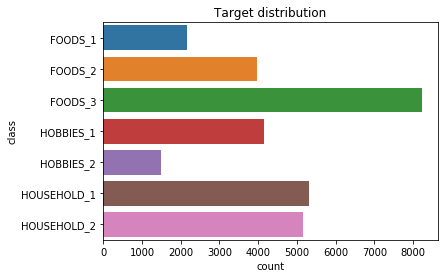

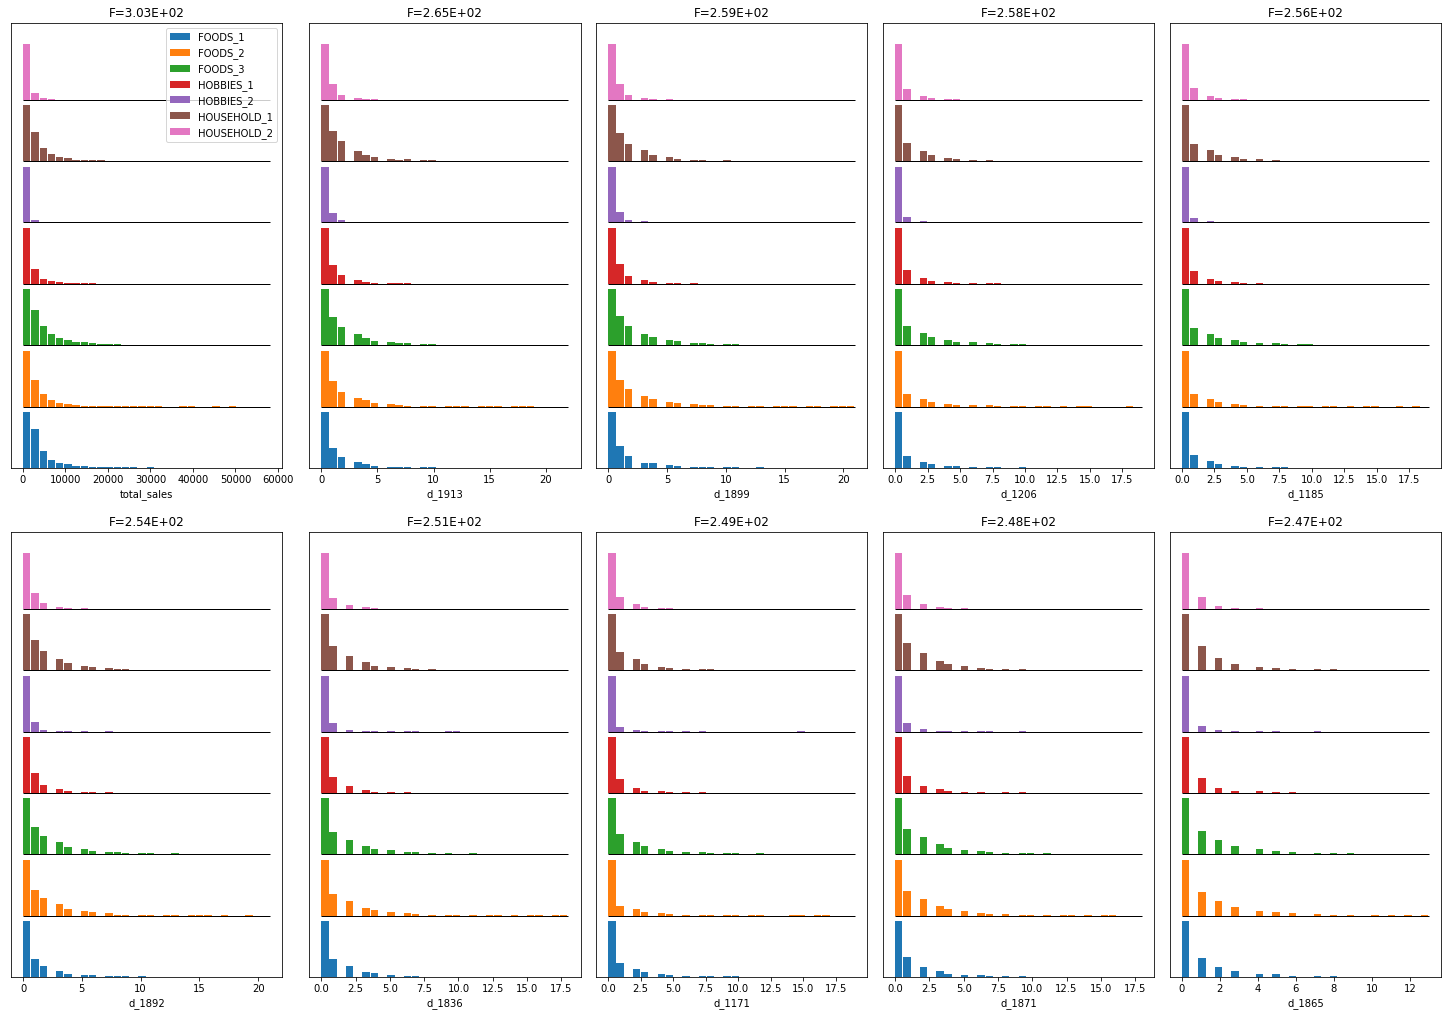

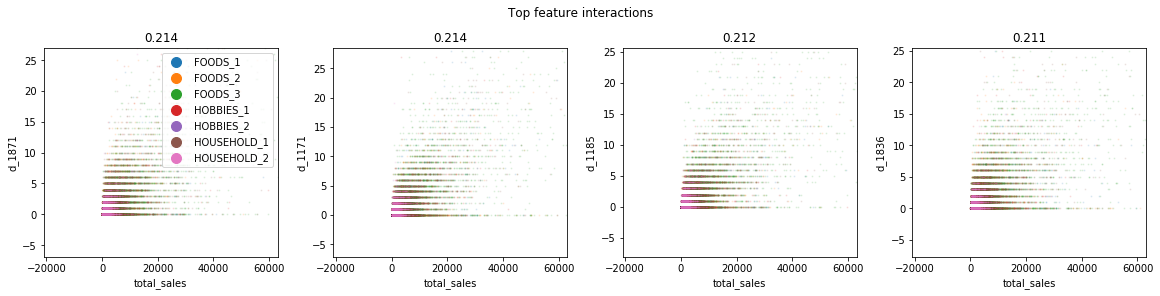

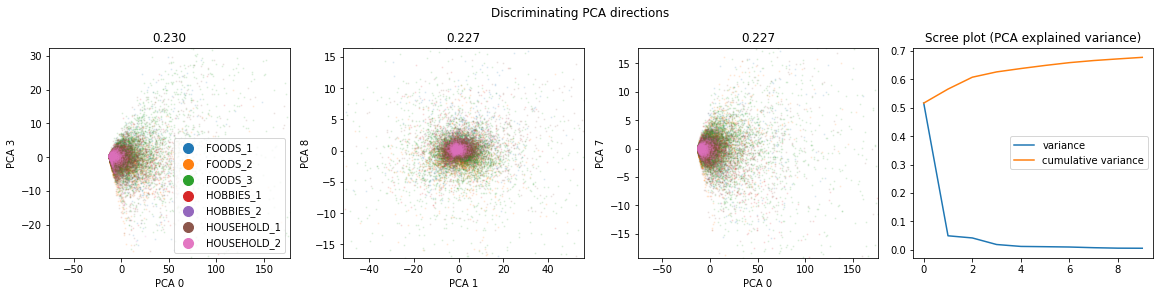

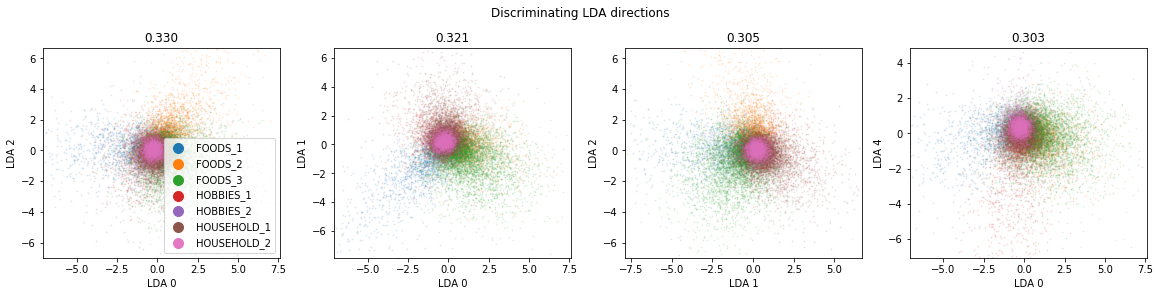

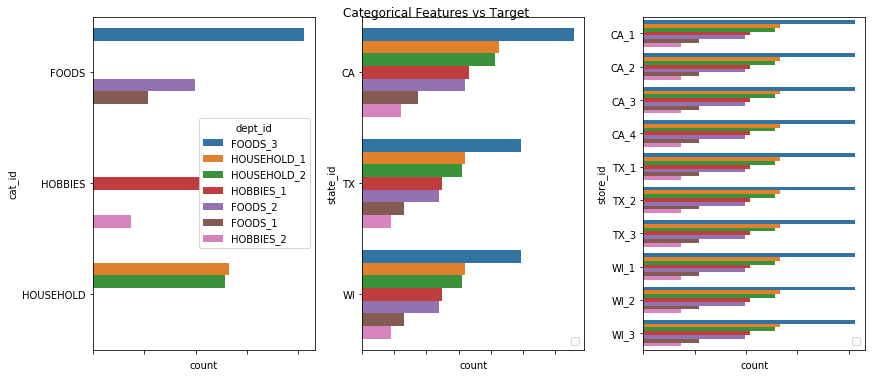

In [42]:
### Retrieved from: https://www.kaggle.com/deepakdeepu8978/m5-competition-explore-eda-models ###
from dabl import plot

plot(sales_train_valid_df, 'dept_id')
plt.show()

The plots above display the distributions of the features of the dataset and their interactions with each other.  This is useful in preparing the data for modeling.  I can see the distributions of the features are skewd right and need to be normalized with the standard scaler from scikit learn library.  I will do this in the modeling notebooks. 

# EDA of Store CA_1

Reference:

https://www.kaggle.com/gopidurgaprasad/m5-forecasting-eda-lstm-pytorch-modeling

In [43]:
# Resetting the dataframe variables.
calendar = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')
sales = pd.read_csv('sales_train_validation.csv')

In [44]:
# Data preprocessing for EDA.
sales_melt = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id',
                                     'state_id'], var_name='day', value_name='demand')

sales_CA_1 = sales_melt[sales_melt.store_id == "CA_1"]
new_CA_1 = pd.merge(sales_CA_1, calendar, left_on="day", right_on="d", how="left")
new_CA_1 = pd.merge(new_CA_1, prices, left_on=["store_id", "item_id", "wm_yr_wk"],
                    right_on=["store_id", "item_id", "wm_yr_wk"], how="left")

new_CA_1["day_int"] = new_CA_1.day.apply(lambda x: int(x.split("_")[-1]))

new_CA_1.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  day  demand       date  wm_yr_wk  ...    d  event_name_1  \
0       CA  d_1       0  1/29/2011     11101  ...  d_1           NaN   
1       CA  d_1       0  1/29/2011     11101  ...  d_1           NaN   
2       CA  d_1       0  1/29/2011     11101  ...  d_1           NaN   
3       CA  d_1       0  1/29/2011     11101  ...  d_1           NaN   
4       CA  d_1       0  1/29/2011     11101  ...  d_1           NaN   

   event_type_1  event_name_2 event_type_2 snap_CA snap_TX snap_WI sell_price  \
0           NaN           NaN          NaN       0       0       0        NaN   
1           NaN           NaN          NaN       0       0       0        NaN   
2           NaN           NaN          NaN       0       0       0        NaN   
3           NaN           NaN          NaN       0       0       0        NaN   
4           NaN           NaN          NaN       0       0       0        NaN   

   day_int  
0        1  
1        1  
2        1  
3        1  
4        1  

[5 rows x 24 columns]

In [45]:
# Demand each day for store CA_1.
day_sum = new_CA_1.groupby("day_int")[["sell_price", "demand"]].agg("sum").reset_index()

In [46]:
# Plot demand and sell price for store CA_1.
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=day_sum.day_int, 
                         y=day_sum.demand,
                         mode="lines",
                         name="demand",
                         ),

              row=1,col=1         
              )

fig.add_trace(go.Scatter(x=day_sum.day_int, 
                         y=day_sum.sell_price,
                         mode="lines",
                         name="sell_price"
                         ),
             
              row=2,col=1           
              )

fig.update_layout(height=1000, title_text="SUM -> Demand  and Sell_price")
fig.show()

An observation of demand and sell_price is as time increase demand and sell_price increases.  Demand follows a similar pattern as total sales.  Demand in store CA_1 is representative of sales data.  The data has seasonality; therefore, does not have stationarity.  Before modeling, I will preprocessing the data to correct for seasonality.  

In [47]:
# For each day we count_nonzeros over products sell_price and demand
day_sum = new_CA_1.groupby("day_int")[["demand","event_name_1" ]].agg({"demand": np.count_nonzero, "event_name_1": "first"}).reset_index()
def count_nulls(series):
    return len(series) - series.count()

cout_null = new_CA_1.groupby("day_int")["sell_price"].agg(count_nulls).reset_index()

In [48]:
# Plot sell_price and demand for nonzero count.
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=cout_null.day_int, 
                         y=cout_null.sell_price,
                         mode="lines",
                         name="sell_price",
                        ),

              row=1,col=1         
              )

fig.add_trace(go.Scatter(x=day_sum.day_int, 
                         y=day_sum.demand,
                         mode="lines",
                         name="demand",
                        ),
             
              row=2,col=1           
              )

fig.update_layout(height=1000, title_text="Count_Nonzero -> Sell_price  and Demand")
fig.show()

In the plots above, I wanted to look at demand and sell_price nonzero count.  I can see demand different and can see an increasing trend to the data.  The demand plot still shows seasonality.  The sell_price plot shows a significant decrease.

In [49]:
# For each item we get max, mean, min over days sell_price and demand. 
item_id = new_CA_1.groupby("item_id")[["sell_price", "demand"]].agg({
    "sell_price": ["max", "mean", "min"],
    "demand" : ["max", "mean", "min"]
}).reset_index()

In [50]:
# Plot each item over the days for sell_price max, mean, and min.
fig = make_subplots(rows=1, cols=1)

item_id = item_id.sort_values(("sell_price", "max"))
fig.add_trace(go.Scatter(x=item_id["item_id"], 
                         y=item_id["sell_price", "max"],
                         mode="lines",
                         name="max",
                         ),

              row=1,col=1         
              )

fig.add_trace(go.Scatter(x=item_id["item_id"], 
                         y=item_id["sell_price", "mean"],
                         mode="lines",
                         name="mean",
                         ),
             
              row=1,col=1           
              )

fig.add_trace(go.Scatter(x=item_id["item_id"], 
                         y=item_id["sell_price", "min"],
                         mode="lines",
                         name="min",
                         ),
             
              row=1,col=1           
              )

fig.update_layout(height=500, title_text="Sell_price")
fig.show()

In [57]:
# Plot each item over the days for demand max, mean, and min.
fig = make_subplots(rows=1, cols=1)

item_id = item_id.sort_values(("demand", "max"))
fig.add_trace(go.Scatter(x=item_id["item_id"], 
                         y=item_id["demand", "max"],
                         mode="lines",
                         name="max",
                         ),

              row=1,col=1         
              )

fig.add_trace(go.Scatter(x=item_id["item_id"], 
                         y=item_id["demand", "mean"],
                         mode="lines",
                         name="mean",
                         ),
             
              row=1,col=1           
              )
fig.add_trace(go.Scatter(x=item_id["item_id"], 
                         y=item_id["demand", "min"],
                         mode="lines",
                         name="min",
                         ),
             
              row=1,col=1           
              )

fig.update_layout(height=500, title_text="Demand")
fig.show()

In [51]:
# Event days.
events = new_CA_1[~new_CA_1.event_name_1.isna()]
events = events.groupby("event_name_1")[["demand", "sell_price"]].agg(["mean", "max"]).reset_index()
events.columns = ['_'.join(col).strip() for col in events.columns.values]

In [52]:
# Plot demand for event days.
fig = go.Figure()

fig.add_trace(go.Scatter(x=events["event_name_1_"],
                         y=events["demand_mean"],
                         mode="lines",
                         name="week_day"
))

fig.update_layout(height=500, title_text="Demand")
fig.show()

Based on the plot above, I can see the demand at store CA_1 for Labor Day is the highest of the event days.  The lowest demand is during Christmas and Thanksgiving because of the modified store hours (Closed on Christmas, Limited Hours on Thanksgiving).  This is useful to the manager.  The manager will need to plan for Labor Day' staffing and inventory. 

In [53]:
# Plot sell_price for event days.
fig = go.Figure()

fig.add_trace(go.Scatter(x=events["event_name_1_"],
                         y=events["sell_price_mean"],
                         mode="lines",
                         name="week_day"

))

fig.update_layout(height=500, title_text="Sell_price")
fig.show()

According to the plot above, I can see the sum of sell_price is lowest during Father's Day and highest during Easter.

In [54]:
# Demand and sell_price mean for each department.
dep = new_CA_1.groupby(["day_int","dept_id"])[["demand", "sell_price"]].agg(["mean", "max"]).reset_index()
dep.columns = ['_'.join(col).strip() for col in dep.columns.values]

In [60]:
# Plot mean demand for each department.
fig = make_subplots(rows=1, cols=1)

for each_dep in dep.dept_id_.unique():
    dep_df = dep[dep.dept_id_ == each_dep]
    fig.add_trace(go.Scatter(x=dep_df["day_int_"], 
                             y=dep_df["demand_mean"],
                             mode="lines",
                             name=each_dep,
                             ),

                  row=1,col=1         
                  )
    
fig.update_layout(title_text="Demand Mean Over Departments day-by-day")
fig.show()

I can clearly see FOODS_3 item has the highest demand of all the items.  The manager will need to ensure FOODS_3 item is always stocked.  FOODS are the highest demanded category in store CA_1 same as in all the stores.

In [59]:
# Plot mean sell_price for each department.
fig = make_subplots(rows=1, cols=1)

for each_dep in dep.dept_id_.unique():
    dep_df = dep[dep.dept_id_ == each_dep]
    fig.add_trace(go.Scatter(x=dep_df["day_int_"], 
                             y=dep_df["sell_price_mean"],
                             mode="lines",
                             name=each_dep,
                             ),

                  row=1,col=1         
                  )
    
fig.update_layout(title_text="Sell Prices Mean Over Departments day-by-day")
fig.show()

The plot for the sum of sell_price for the different departments show HOBBIES and HOUSEHOLD have the highest priced items versus food.